---
# 1) Resumo

Neste notebook foram feitos os treinamentos e seleção de hyperparamentros de 6 modelos de **ML** distintos. Os modelos estudados foram:

* DummyClassifier
* LogisticRegression
* DecisionTreeClassifier
* Forest Tree
* Support Vector Machine
* KNeighbors

A busca pelos hyperparametros foram feitas pelo GridSearchCV ou pelo RandomizedSearchCV. Para a Cross Validation foi usado **RepeatedStratifiedKFold** com **5** divições de **10** repetições.

O parametro utilizado para avaliação do modelo foi **ROC_AUC** e quantidade de **falsos negativos** (FN).

A base de dados utilizados tem **351** amostras com **52** variaveis explicativas. Dessas **351** amostras **298** foram usados para **Cross Validation** (treino + teste) e **53** foram usados para a **validação**.


---
# 2) Pre-analise

---
## 2.1) Minhas Funções

In [23]:
collab=False #Notebook roda no collab ?  

if (collab):
  !pip install matplotlib==3.4.2
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/plota_graficos.py"
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/ml.py"
  !wget "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/src/info.py"

  from plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
  from ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                 treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos

  from info import proporcao_y, porcentagem_teste_treino_val, resultados_treinamento, dimensao_dados

else:
  import sys
  sys.path.insert(1, "../../")

  from src.plota_graficos import plota_treino_teste_auc, plota_curva_roc, plota_matriz_de_confusao
  from src.ml import retorna_x_y, intervalo_de_confianca, treina_modelo_grid_search_cv,\
                   treina_modelo_randomized_search_cv, obtem_os_resultados_SearchCV, cv_val_split, desempenho_dos_modelos 

  from src.info import proporcao_y, numero_teste_treino_val, resultados_treinamento, dimensao_dados

---
## 2.2) Importando libs

In [24]:
import pandas as pd
#
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
#
import matplotlib.pyplot as plt
#
import numpy as np
#
from scipy.stats import uniform

---
# 3) Lendo os dados

In [25]:
path = "https://raw.githubusercontent.com/HenriqueCCdA/BC_DS_Projeto_Final/main/Dados/Tratados/dados_sem_coor_acima_do_valor_de_corte.csv"

dados_com_corte = pd.read_csv(path)

dimensao_dados(dados_com_corte)

dados_com_corte.tail(n=5)

Numero de linhas : 351 
Numero de colunas: 53 


,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
346,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.860241,-0.978029,-0.160494,-0.692308,0.339623,-0.457627,0.142857,0.736842,-0.418803,1
347,1,1.000000,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.855422,-0.978029,-0.407407,-0.692308,-0.283019,-0.457627,-0.059524,0.526316,-0.589744,0
348,0,-0.111111,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.787952,-0.964461,0.012346,-0.384615,-0.320755,-0.457627,-0.071429,0.894737,-0.299145,1
349,0,-0.333333,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.937349,-0.978029,0.086420,-0.230769,-0.301887,-0.661017,-0.107143,0.736842,-0.247863,0
350,0,-0.111111,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.879518,-0.979571,0.012346,-0.292308,0.056604,-0.525424,0.535714,0.789474,-0.299145,0


In [26]:
dados_com_corte.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 351 entries, 0 to 350
Data columns (total 53 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   AGE_ABOVE65                   351 non-null    int64  
 1   AGE_PERCENTIL                 351 non-null    float64
 2   GENDER                        351 non-null    int64  
 3   DISEASE GROUPING 1            351 non-null    float64
 4   DISEASE GROUPING 2            351 non-null    float64
 5   DISEASE GROUPING 3            351 non-null    float64
 6   DISEASE GROUPING 4            351 non-null    float64
 7   DISEASE GROUPING 5            351 non-null    float64
 8   DISEASE GROUPING 6            351 non-null    float64
 9   HTN                           351 non-null    float64
 10  IMMUNOCOMPROMISED             351 non-null    float64
 11  OTHER                         351 non-null    float64
 12  ALBUMIN_MEDIAN                351 non-null    float64
 13  BE_AR

In [27]:
dados_com_corte.describe()

,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,...,UREA_MEDIAN,DIMER_MEDIAN,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MAX,ICU
count,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,...,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000,351.000000
mean,0.458689,-0.046534,0.381766,0.108262,0.022792,0.091168,0.019943,0.128205,0.045584,0.196581,...,-0.841746,-0.960159,-0.045990,-0.318411,-0.240403,-0.468207,0.097772,0.760029,-0.313074,0.461538
std,0.499002,0.640366,0.486513,0.311155,0.149453,0.288259,0.140004,0.334795,0.208879,0.397980,...,0.135197,0.098682,0.253692,0.274796,0.278347,0.213326,0.272230,0.116880,0.185592,0.499230
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.971084,-1.000000,-0.654321,-0.938462,-0.823899,-0.954802,-0.571429,0.263158,-0.760684,0.000000
25%,0.000000,-0.555556,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.898795,-0.983811,-0.185185,-0.538462,-0.415094,-0.593220,-0.107143,0.684211,-0.418803,0.000000
50%,0.000000,-0.111111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.874699,-0.978029,-0.037037,-0.369231,-0.283019,-0.525424,0.071429,0.789474,-0.299145,0.000000
75%,1.000000,0.555556,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.821687,-0.971784,0.086420,-0.153846,-0.094340,-0.389831,0.250000,0.842105,-0.213675,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.513241,0.604938,0.553846,1.000000,0.830508,0.964286,1.000000,0.487179,1.000000


### Divindido os dados em validação e Cross Valadiation (teste+treino)

In [28]:
x_cv, x_val, y_cv, y_val = cv_val_split(dados_com_corte, p_val = .15)

### Verificando se a proporção foi mantida 

In [29]:
proporcao_y(dados_com_corte['ICU'])
proporcao_y(y_val)
proporcao_y(y_cv )

Proporcao do ICU
Campo 0 ->  53.85%
Campo 1 ->  46.15%
Proporcao do ICU
Campo 0 ->  54.72%
Campo 1 ->  45.28%
Proporcao do ICU
Campo 0 ->  53.69%
Campo 1 ->  46.31%


In [30]:
numero_teste_treino_val(dados_com_corte['ICU'], y_val, y_cv)

Número total de entradas                         : 351
Número total de entradas para validacao          : 53
Número total de entradas para o Cross Validation : 298


# 4) Modelo de ML

A opção **refit** foi deixado como **true** logo depois que o melhor modelo for selecioando o RandomizedSearchCV/GridSearchCv **re-treina** esse modelo com o dataset completo (treino+teste). 

In [31]:
n_iter   = 20
n_splits = 5
n_repeats= 10

## 4.1) DummyClassifier

> Aqui será treinado do modelo **DummyClassifier**. Para o treino foi usado **GridSearchCV**. O único hyperparametro disponivel foi **strategy**. O intervalor de busca  **[stratified, 'ost_frequent, prior, 'uniform]**. O DummyClassifier será usado como o nosso modelo **"baseline"**



In [32]:
modelo = DummyClassifier(random_state=141715)

parameters = {'strategy' : ['stratified', 'most_frequent', 'prior', 'uniform']}

resultados, melhor_modelo_dummy, melhores_hyperparametros  = treina_modelo_grid_search_cv(modelo,
                                                                                      x_cv,
                                                                                      y_cv,
                                                                                      parameters,
                                                                                      n_splits=n_splits,
                                                                                      n_repeats=n_repeats,
                                                                                      seed=14715)

resultados_treinamento(resultados, melhor_modelo_dummy, melhores_hyperparametros)

Fitting 50 folds for each of 4 candidates, totalling 200 fits
melhores hyperparametros : {'strategy': 'most_frequent'}
Melhor modelo            : DummyClassifier(random_state=141715, strategy='most_frequent')


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'strategy': 'stratified'},0.494263,0.506071,0.052608,0.030333,0.002119,0.000972,0.002958,0.000893,4
1,{'strategy': 'most_frequent'},0.500000,0.500000,0.000000,0.000000,0.001739,0.000559,0.002798,0.000632,1
2,{'strategy': 'prior'},0.500000,0.500000,0.000000,0.000000,0.001679,0.000614,0.002798,0.000490,1
3,{'strategy': 'uniform'},0.500000,0.500000,0.000000,0.000000,0.001999,0.000489,0.002579,0.000635,1


---
## 4.2) Regreção logistica

> Aqui será treinado do modelo **LogisticRegression**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* C             : [0, 2]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


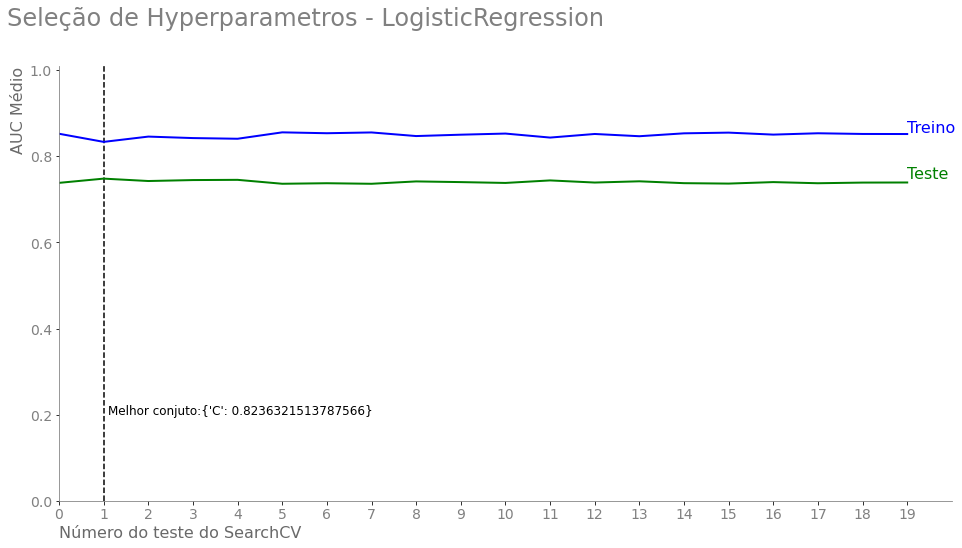

melhores hyperparametros : {'C': 0.8236321513787566}
Melhor modelo            : LogisticRegression(C=0.8236321513787566, max_iter=1000, tol=1e-06)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,{'C': 2.9403726439047437},0.738411,0.852465,0.056743,0.012051,0.061963,0.011797,0.006186,0.001080,13
1,{'C': 0.8236321513787566},0.748252,0.833586,0.056711,0.011813,0.035558,0.007851,0.006376,0.001412,1
2,{'C': 1.8107081253404766},0.742681,0.845862,0.057104,0.011928,0.050000,0.015470,0.006366,0.001465,5
3,{'C': 1.4507591152545065},0.744900,0.842424,0.056824,0.011890,0.042025,0.007929,0.006076,0.001197,3
4,{'C': 1.3163817298661398},0.745422,0.840848,0.056739,0.011984,0.051259,0.063614,0.006656,0.002044,2
5,{'C': 3.7627108804741063},0.736314,0.855717,0.056273,0.011931,0.067879,0.011942,0.006176,0.000747,19
6,{'C': 3.2348466053974367},0.737560,0.853678,0.056854,0.012027,0.064481,0.013448,0.006176,0.001419,16
7,{'C': 3.6987640689695644},0.736270,0.855502,0.056289,0.011954,0.069958,0.014121,0.006356,0.001352,20
8,{'C': 1.9704679412547428},0.741779,0.847110,0.057192,0.011929,0.046941,0.005013,0.006096,0.000671,7
9,{'C': 2.4854242092996466},0.740159,0.850289,0.057007,0.011949,0.056526,0.011274,0.006456,0.001359,9


In [33]:
parameters = {'C': uniform(loc=0, scale=4)}
modelo = LogisticRegression(max_iter=1000, tol=1e-6)

resultados, melhor_modelo_lr, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - LogisticRegression', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_lr, melhores_hyperparametros, n = 10)

---
## 4.3) Arvore de decissão

> Aqui será treinado do modelo **DecisionTreeClassifier**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros foram:
>* max_depth       : [1-20]
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


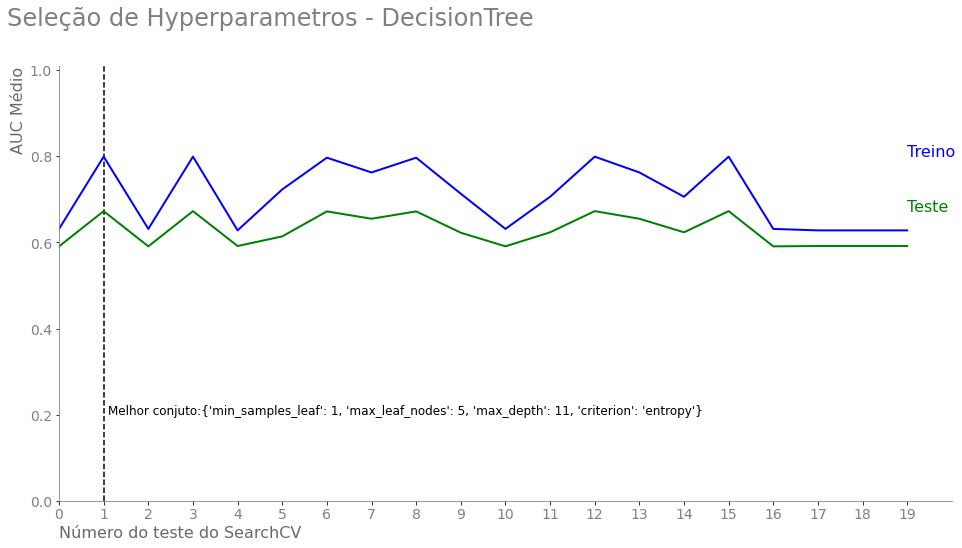

melhores hyperparametros : {'min_samples_leaf': 1, 'max_leaf_nodes': 5, 'max_depth': 11, 'criterion': 'entropy'}
Melhor modelo            : DecisionTreeClassifier(criterion='entropy', max_depth=11, max_leaf_nodes=5)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.590954,0.631444,0.050327,0.016861,0.007314,0.001759,0.007138,0.004220,17
1,"{'min_samples_leaf': 1, 'max_leaf_nodes': 5, '...",0.672723,0.799308,0.077351,0.014636,0.011054,0.002292,0.007856,0.004231,1
2,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.590954,0.631444,0.050327,0.016861,0.008908,0.004919,0.007776,0.004429,17
3,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.672723,0.799308,0.077351,0.014636,0.009843,0.000883,0.006269,0.000784,1
4,"{'min_samples_leaf': 5, 'max_leaf_nodes': 2, '...",0.591749,0.628040,0.055339,0.017174,0.007835,0.000833,0.006243,0.000869,13
5,"{'min_samples_leaf': 4, 'max_leaf_nodes': 5, '...",0.614050,0.723210,0.059086,0.019828,0.006900,0.000694,0.006032,0.000889,12
6,"{'min_samples_leaf': 2, 'max_leaf_nodes': 5, '...",0.672125,0.796885,0.072134,0.014045,0.008153,0.000830,0.006248,0.000749,5
7,"{'min_samples_leaf': 3, 'max_leaf_nodes': 4, '...",0.655082,0.762585,0.069723,0.021004,0.009994,0.002039,0.006628,0.001497,7
8,"{'min_samples_leaf': 3, 'max_leaf_nodes': 5, '...",0.672125,0.796885,0.072134,0.014045,0.008322,0.001039,0.006460,0.000756,5
9,"{'min_samples_leaf': 3, 'max_leaf_nodes': 3, '...",0.622662,0.713134,0.060568,0.015628,0.007665,0.000771,0.006296,0.000877,11


In [34]:
parameters = {'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = DecisionTreeClassifier()

resultados, melhor_modelo_arvore, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)
plota_treino_teste_auc('Seleção de Hyperparametros - DecisionTree', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_arvore, melhores_hyperparametros, n = 10)

---
## 4.4) Forest Tree

> Aqui será treinado do modelo **Forest Tree**. No treino foi usado **RandomizedSearchCV** com **10** iterações. Os hyperparametros foram:
>* n_estimators    : [10, 50, 100, 150, 200]
>* max_depth       : [1, 20]    
>* criterion       : [gini, entropy]
>* min_samples_leaf: [1-5]
>* max_leaf_nodes  : [2-5]


Fitting 50 folds for each of 20 candidates, totalling 1000 fits


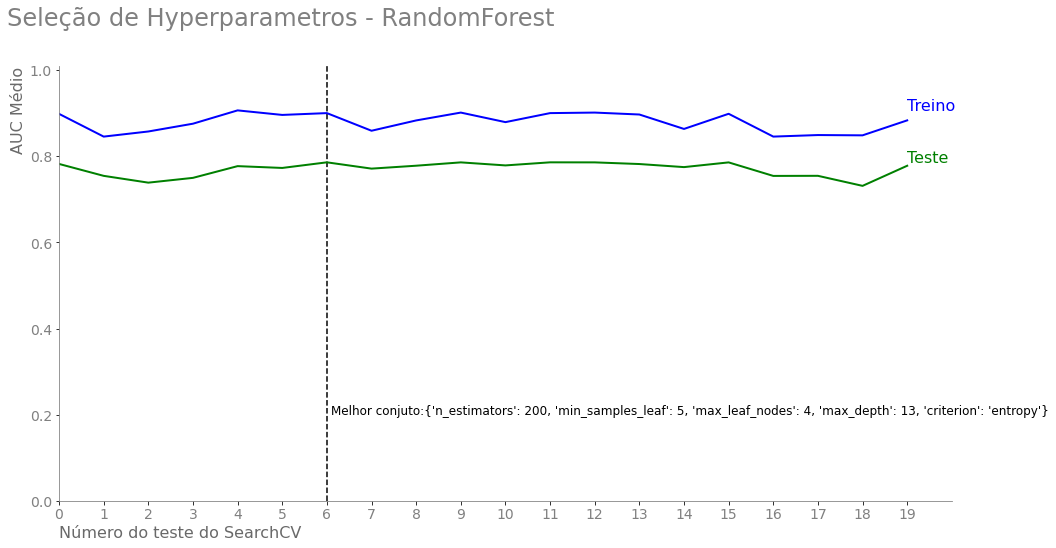

melhores hyperparametros : {'n_estimators': 200, 'min_samples_leaf': 5, 'max_leaf_nodes': 4, 'max_depth': 13, 'criterion': 'entropy'}
Melhor modelo            : RandomForestClassifier(criterion='entropy', max_depth=13, max_leaf_nodes=4,
                       min_samples_leaf=5, n_estimators=200, random_state=0)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'n_estimators': 200, 'min_samples_leaf': 3, '...",0.782360,0.898664,0.057738,0.008851,0.556452,0.053294,0.049914,0.006078,6
1,"{'n_estimators': 50, 'min_samples_leaf': 4, 'm...",0.754697,0.845841,0.055497,0.012643,0.142413,0.011392,0.017930,0.002309,16
2,"{'n_estimators': 10, 'min_samples_leaf': 2, 'm...",0.738901,0.857729,0.054091,0.015517,0.035134,0.004614,0.009533,0.001872,19
3,"{'n_estimators': 10, 'min_samples_leaf': 4, 'm...",0.750022,0.875820,0.056953,0.012911,0.034271,0.000705,0.008895,0.000671,18
4,"{'n_estimators': 50, 'min_samples_leaf': 5, 'm...",0.777261,0.906737,0.053835,0.008188,0.151709,0.019379,0.018710,0.005480,11
5,"{'n_estimators': 50, 'min_samples_leaf': 3, 'm...",0.773051,0.896195,0.054644,0.009829,0.154243,0.013536,0.017890,0.002476,13
6,"{'n_estimators': 200, 'min_samples_leaf': 5, '...",0.786086,0.900408,0.056616,0.009004,0.602740,0.060755,0.051309,0.008187,1
7,"{'n_estimators': 150, 'min_samples_leaf': 4, '...",0.771479,0.859446,0.057722,0.011176,0.419351,0.042032,0.038759,0.005080,14
8,"{'n_estimators': 100, 'min_samples_leaf': 3, '...",0.778230,0.883398,0.058213,0.010704,0.299388,0.037908,0.028568,0.003867,9
9,"{'n_estimators': 200, 'min_samples_leaf': 3, '...",0.785979,0.901638,0.056713,0.008947,0.599883,0.044740,0.050963,0.007815,3


In [35]:
parameters = {'n_estimators'    : [10, 50, 100, 150, 200],
              'max_depth'       : np.arange(1, 21),
              'criterion'       : ['gini', 'entropy'],
              'min_samples_leaf': np.arange(1, 6),
              'max_leaf_nodes'  : np.arange(2, 6)
             }
modelo = RandomForestClassifier(random_state=0)

resultados, melhor_modelo_forest, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - RandomForest', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_forest, melhores_hyperparametros, n = 10)

> 

## 4.5) Support Vector Classification.

> Aqui será treinado do modelo **SVC**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* kernel        : [linear, poly, rbf, sigmoid]
>* C             : [0, 2]
>* gamma         : [scale, auto]
>* shrinking     : [True , False]

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


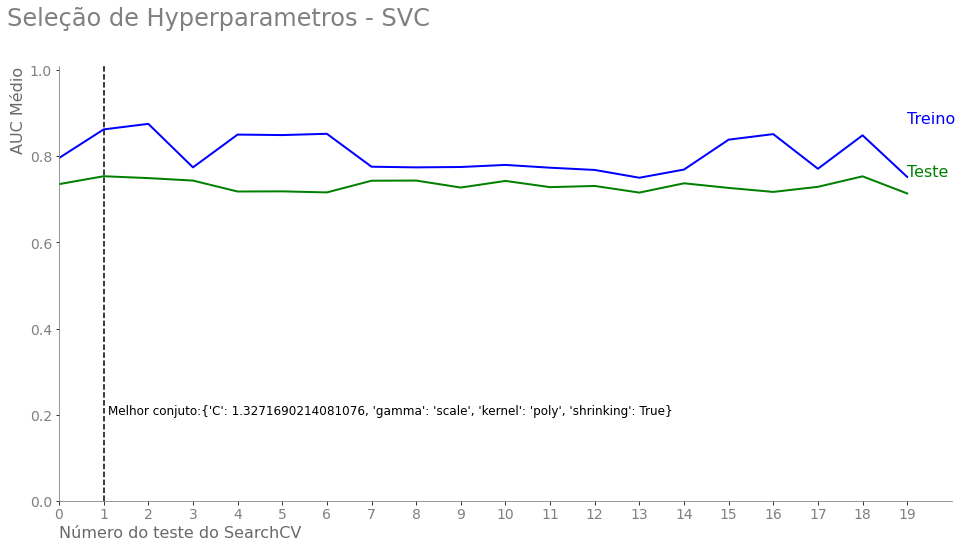

melhores hyperparametros : {'C': 1.3271690214081076, 'gamma': 'scale', 'kernel': 'poly', 'shrinking': True}
Melhor modelo            : SVC(C=1.3271690214081076, kernel='poly', probability=True)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'C': 1.4701863219523719, 'gamma': 'auto', 'ke...",0.735446,0.796118,0.059342,0.013347,0.043369,0.004173,0.009848,0.001604,9
1,"{'C': 1.3271690214081076, 'gamma': 'scale', 'k...",0.753791,0.862561,0.059627,0.010265,0.029012,0.001232,0.007216,0.000855,1
2,"{'C': 1.8813554402370531, 'gamma': 'scale', 'k...",0.749478,0.875456,0.059759,0.009850,0.029189,0.001056,0.007356,0.000819,3
3,"{'C': 0.872565127799168, 'gamma': 'auto', 'ker...",0.743697,0.774409,0.056791,0.011751,0.031340,0.000685,0.007136,0.000693,5
4,"{'C': 1.5194866996222245, 'gamma': 'auto', 'ke...",0.718337,0.850550,0.062503,0.013231,0.040266,0.004940,0.007468,0.001475,16
5,"{'C': 1.375029228314785, 'gamma': 'auto', 'ker...",0.718677,0.849386,0.061709,0.013252,0.031919,0.002365,0.007255,0.001014,15
6,"{'C': 1.7923741955744268, 'gamma': 'scale', 'k...",0.716233,0.852375,0.062761,0.013459,0.042246,0.003216,0.006877,0.000789,18
7,"{'C': 1.206530015269424, 'gamma': 'auto', 'ker...",0.743398,0.775894,0.057341,0.012559,0.032207,0.003723,0.007735,0.001352,6
8,"{'C': 0.010175292060016439, 'gamma': 'scale', ...",0.743740,0.774402,0.056774,0.011759,0.032621,0.003436,0.007295,0.001152,4
9,"{'C': 1.8515891573884744, 'gamma': 'auto', 'ke...",0.727555,0.775235,0.059461,0.013598,0.036239,0.001987,0.007616,0.001036,13


In [36]:
parameters = {'kernel'          : ['linear', 'poly', 'rbf', 'sigmoid'],
              'C'               : uniform(loc=0, scale=2),
              'gamma'           : ['scale', 'auto'],
              'shrinking'       : [True, False]
             }

modelo = SVC(probability=True)

resultados, melhor_modelo_svc, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - SVC', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_svc, melhores_hyperparametros, n = 10)

## 4.5) KNeighbors

> Aqui será treinado do modelo **KNeighbor**. No treino foi usado **RandomizedSearchCV** com **50** iterações. Os hyperparametros de busca foram
>* n_neighbors   : [1, 10]
>* p             : [1, 2]
>* weights       : [uniform, distance]
>* algorithm     : [auto, ball_tree, kd_tree, brute]

Fitting 50 folds for each of 20 candidates, totalling 1000 fits


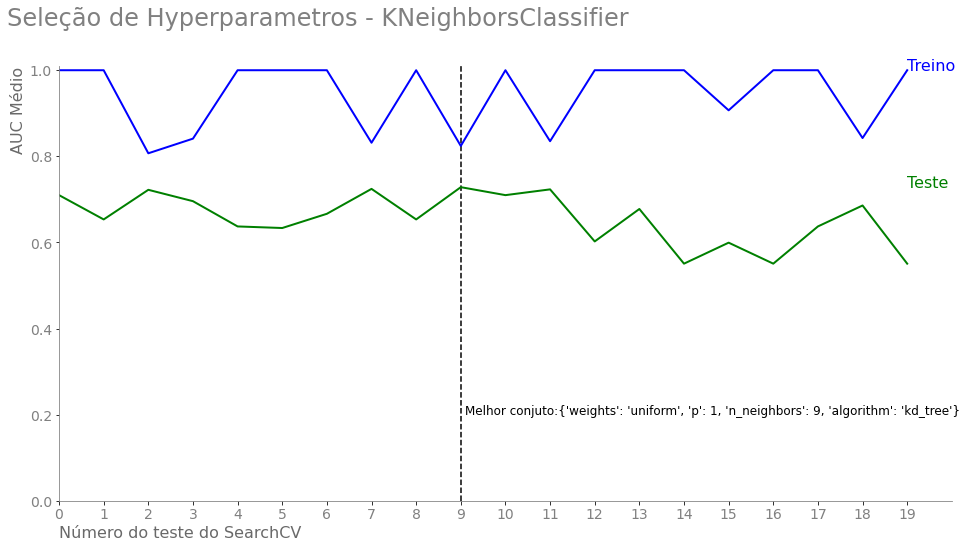

melhores hyperparametros : {'weights': 'uniform', 'p': 1, 'n_neighbors': 9, 'algorithm': 'kd_tree'}
Melhor modelo            : KNeighborsClassifier(algorithm='kd_tree', n_neighbors=9, p=1)


,paramentros,media_teste,media_treino,std_teste,std_treino,mean_fit_time,std_fit_time,mean_score_time,std_score_time,rank_test_score
0,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.709900,1.000000,0.058057,0.000000,0.005919,0.001382,0.008088,0.001808,5
1,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.653469,1.000000,0.061130,0.000000,0.006361,0.002029,0.008438,0.002417,11
2,"{'weights': 'uniform', 'p': 2, 'n_neighbors': ...",0.722271,0.807102,0.060899,0.014816,0.005812,0.000881,0.007876,0.001032,4
3,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.695870,0.841111,0.068274,0.017052,0.006115,0.001176,0.008570,0.001097,7
4,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.637204,1.000000,0.069181,0.000000,0.008885,0.002475,0.010214,0.002255,13
5,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.633538,1.000000,0.060714,0.000000,0.008293,0.001151,0.009016,0.001028,15
6,"{'weights': 'distance', 'p': 1, 'n_neighbors':...",0.666564,1.000000,0.069889,0.000000,0.006255,0.001375,0.009334,0.002034,10
7,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.724422,0.831628,0.061463,0.014170,0.006205,0.001214,0.008856,0.001413,2
8,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.653469,1.000000,0.061130,0.000000,0.008394,0.002029,0.009782,0.002012,11
9,"{'weights': 'uniform', 'p': 1, 'n_neighbors': ...",0.728404,0.824156,0.061109,0.013222,0.008456,0.001202,0.009804,0.001306,1


In [37]:
parameters = {'n_neighbors'     : np.arange(1, 11),
              'p'               : [1, 2],
              'weights'         : ['uniform', 'distance'],
              'algorithm'       : ['auto', 'ball_tree', 'kd_tree', 'brute']
             }

modelo = KNeighborsClassifier()

resultados, melhor_modelo_kn, melhores_hyperparametros  = treina_modelo_randomized_search_cv(modelo,
                                                                                            x_cv,
                                                                                            y_cv,
                                                                                            parameters,
                                                                                            n_splits=n_splits,
                                                                                            n_repeats=n_repeats,
                                                                                            n_iter=n_iter,
                                                                                            seed=14715)

plota_treino_teste_auc('Seleção de Hyperparametros - KNeighborsClassifier', 
                       resultados['media_teste'],
                       resultados['media_treino'],
                       resultados['rank_test_score'],
                       melhores_hyperparametros)

resultados_treinamento(resultados, melhor_modelo_kn, melhores_hyperparametros, n = 10)

# 5) Avaliando o melhor modelo

> Agora vamos avaliar o melhor modelo encontrado utilizando o dados de validação.

In [38]:
modelos = [melhor_modelo_dummy, 
           melhor_modelo_lr, 
           melhor_modelo_arvore, 
           melhor_modelo_forest, 
           melhor_modelo_svc,
           melhor_modelo_kn] 

In [39]:
desempenho_dos_modelos(modelos, x_val, y_val)

,Name,tn,fp,fn,tp,AUC
0,LogisticRegression,27,2,6,18,0.915230
1,SVC,26,3,5,19,0.915230
2,RandomForestClassifier,26,3,8,16,0.887931
3,DecisionTreeClassifier,20,9,3,21,0.826149
4,KNeighborsClassifier,28,1,16,8,0.819684
5,DummyClassifier,29,0,24,0,0.500000


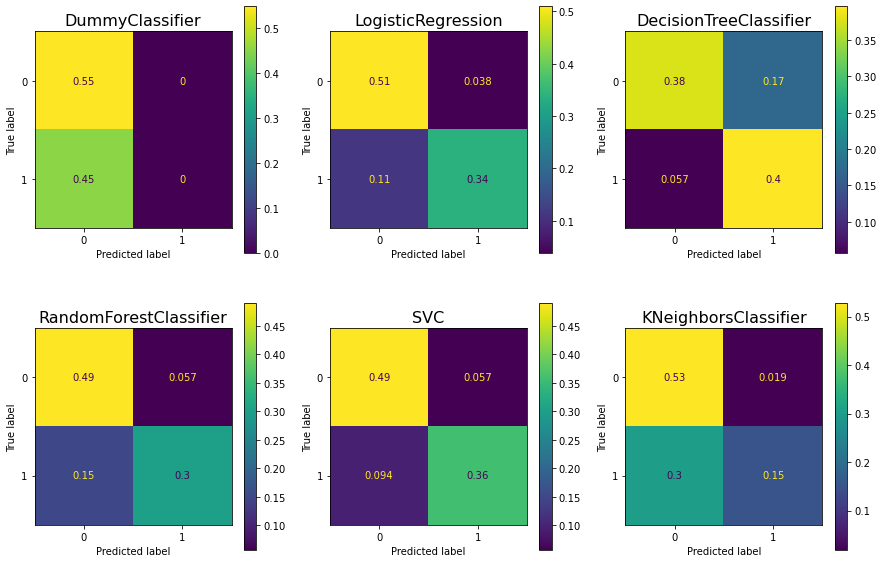

In [40]:
plota_matriz_de_confusao(modelos, x_val, y_val)

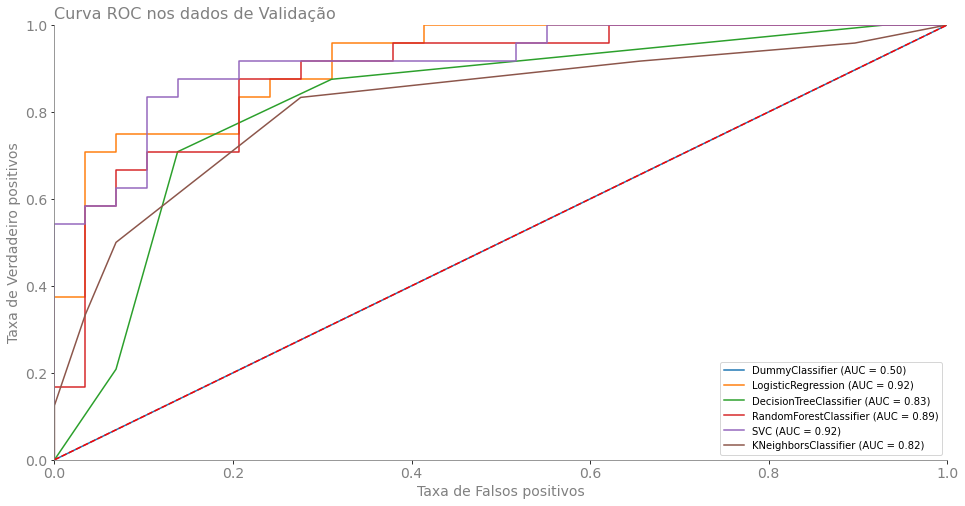

In [41]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Validação', x=x_val, y=y_val)

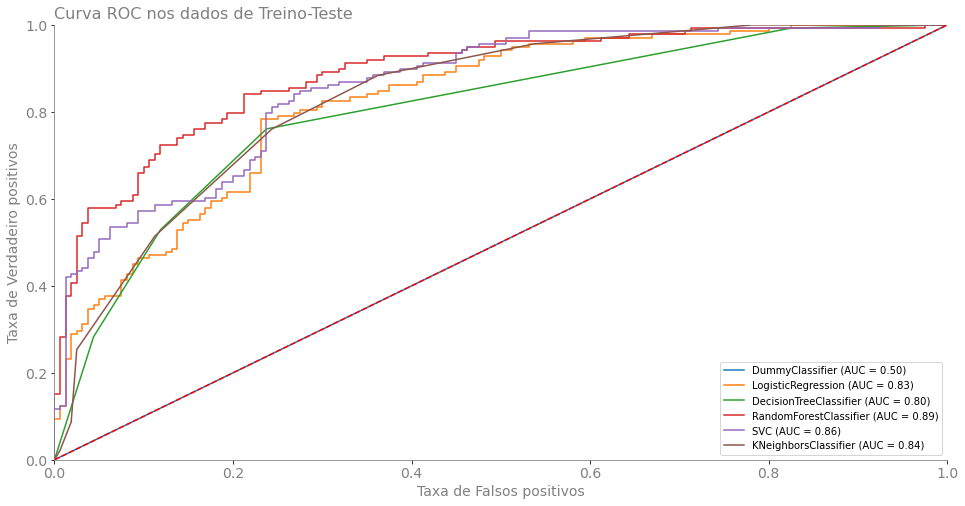

In [42]:
plota_curva_roc(modelos, titulo='Curva ROC nos dados de Treino-Teste', x=x_cv, y=y_cv)